Generating Data, Noise, and Putting it into a format that is readable by Keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 5.0 MB/s 
     |████████████████████████████████| 51 kB 41.3 MB/s 
     |████████████████████████████████| 78 kB 45.8 MB/s 
     |████████████████████████████████| 45 kB 37.6 MB/s 
     |████████████████████████████████| 1.4 MB 44.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.3 MB 32.9 MB/s 
     |████████████████████████████████| 201 kB 56.7 MB/s 
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
     |████████████████████████████████| 45 kB 46.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 55 kB 28.6 MB/s 
     |████████████████████████████████| 295 kB 63.6 MB/s 
     |███████████

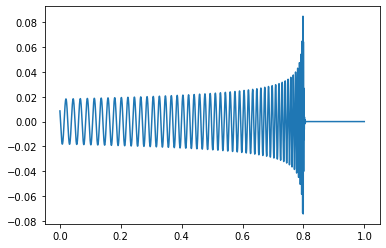

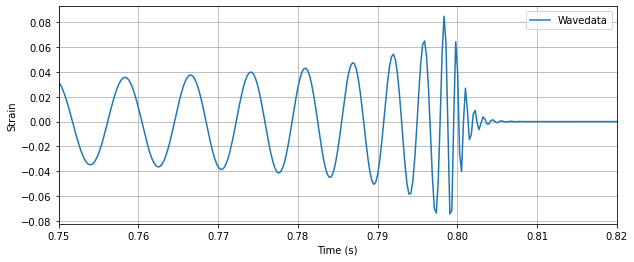

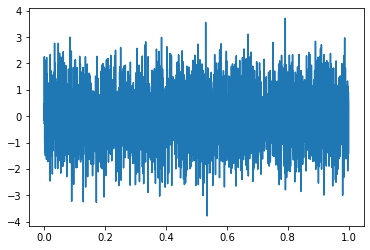

(500, 100, 4096, 1) noisydata shape


In [ ]:
#Code redone for OUR purposes. Still has the ability to train batches but will create 1 second long strains to train. (Can change to any x amount of time by changing the "onesec" variable to int(x/(1.0/samplerate))

import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir  #install pycbc
import numpy as np
import matplotlib.pyplot as pp
import pylab
from pycbc.waveform import get_td_waveform

def generate_data(batch_size, sample_rate, mass_range):
    '''
    Function for generating synthetic gravitational waveforms
    for binary mergers of equal masses over a range of masses determined by batch_size and mass_range
    as well as positive class labels. The waveforms are clipped/padded to be 256 steps in length.
    Param: batch_size - Integer number of waveforms to produce
    Param: sample_rate (Hz) - Integer number of measurements per second
    Param: mass_range (solar masses) - List of form [lower_bound, upper_bound] for mass range
    Param: data - list containing generated waveforms as numpy arrays
    '''
    data = []
    mass_step = (mass_range[1]-mass_range[0])/batch_size
    masses = np.arange(mass_range[0], mass_range[1], mass_step) #Return evenly spaced values within a given interval.
    new_times = []
    onesec = int(1/(1.0/sample_rate))
    for i in range(onesec):
        new_times.append(i*1.0/sample_rate)
    for mass in masses:
        #Generating waveform
        wave, _ = get_td_waveform(approximant='IMRPhenomD', mass1=mass, mass2=mass, delta_t=1.0/sample_rate, f_lower=25) #IMRPHENOMD is just some approximant, seonbr4 or whatever works too
        #Cropping/padding to get waveforms of length 1 second
        if len(wave) < onesec:
          randinteger = np.random.randint(0, onesec - len(wave))
          wave = np.pad(wave, (randinteger, onesec-len(wave)-randinteger), 'constant', constant_values = (0,0))
        else:
          wave = wave[len(wave)-onesec:] #get last 3 sec if larger
        #Normalizing waveform
        wave = wave/max(np.correlate(wave, wave, mode="full"))**0.5
        #Saving waveform as numpy array
        data.append(np.asarray(wave))
    labels = np.ones(len(data))
    return np.asarray(data), labels, new_times

def generate_noise(batch_size, sample_rate, sd=1):
    '''
    Function for generating sequences of white noise of fixed length (256) and negative class labels
    Param: batch_size - Integer number of noise sequences to produce
    Param: sample_rate - From previous generate_data function (Integer number of measurements per second)
    Param: sd - Standard deviation of gaussian noise produced
    '''
    noise = []
    onesec = int(1//(1.0/sample_rate))
    for i in range(batch_size):
        temp = np.random.normal(0, sd, onesec)
        noise.append(temp)
    labels = np.zeros(batch_size)
    return noise, labels

def generate_noisy_data(snr, batch_size, sample_rate, mass_range):
    '''
    Function for generating synthetic gravitational waveforms
    with additive gaussian noise of a specified signal-to-noise ratio, positive class labels,
    guassian noise with fixed power, and negative class labels
    Param: snr - Signal to noise ratio
    Params: The rest are identical to generate_data()
    '''
   #Need snr to give our model the ability to train 0 noise (snr=0) and total noise

    #Generate pure waveforms and labels
    raw_data, data_labels, new_times = generate_data(batch_size, sample_rate, mass_range)
    #Compute average power of pure waveforms
    power = avg_power(raw_data, sample_rate)
    #Compute required noise power to achieve specified SNR
    sd = np.sqrt(snr*power)
    #Generating noise of specified power
    signal_noise, _ = generate_noise(batch_size, sample_rate, sd)
    #Combining the data and the noise
    noisy_data = raw_data + signal_noise
    return noisy_data

def avg_power(data, sample_rate):
    '''
    Function for computing the average power of an array of waveforms
    Param: data - Numpy array containing numpy arrays of waveforms
    '''
    powers = []
    onesec = int(1/(1.0/sample_rate))
    #Calculate power of each waveform
    for wave in data:
        powers.append(np.sum(np.square(wave))/onesec)
    #Return mean of powers
    return np.mean(powers)

def combine_data(data, noise, data_labels, noise_labels):
    '''
    Function for combining data, noise, and labels into
    corresponding numpy arrays for training the model
    Param: data - List of waveforms
    Param: data_labels - Numpy array of 1's for positive class
    Param: noise - list of noise sequences
    Param: noise_labels - Numpy array of 0's for negative class
    Output: X - Numpy array of numpy arrays of data/noise
    Output: Y - numpy array containing labels
    '''
    X = []
    #First waves then noise
    for wave in data:
        X.append(wave)
    for sequence in noise:
        X.append(sequence)
    Y = []
    for label in data_labels:
        Y.append(label)
    for label in noise_labels:
        Y.append(label)
    return np.asarray(X)[..., np.newaxis], np.asarray(Y)


#Generate plot of raw "ideal" waveform data

wavedata, labels, newtimes = generate_data(1000, 4096, [10,100]) #vertical line bc this array of 1's is idk even...
pp.plot(newtimes, wavedata[0]) #plots the first generated wave (index 0)
pp.show()

#Zoom in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(newtimes, wavedata[0], label='Wavedata')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(.75, .82)
pylab.legend()
pylab.grid()
pylab.show()

#Generate plot of background gaussian noise

data_noise, labels_noise = generate_noise(1000, 4096, 1) 
pp.plot(newtimes, data_noise[0])
pp.show()

#Juxaposed noise and data AKA "noisy data" 
#noisy_data_vals = generate_noisy_data(0, 1000, 4096, [10,100])  #0 for SNR means generate only SIGNAL (i guess... might have to look into this later seems little weird that signal to noise ratio of 0 generates only signal but that is what my tests were looking like)
#pp.plot(newtimes, noisy_data_vals[1])
#pp.show()

noisydata = []
for i in range(0, 500):
  noisydata.append(generate_noisy_data(i, 100, 4096, [10,100])) #the 100 here is where the 600, 100, ... shape <- comes from
#noisydata = np.array(noisydata)
noisydata = np.asarray(noisydata)[..., np.newaxis]
print(noisydata.shape, 'noisydata shape')


Grav Wave Machine Learning Part. We made some neural network to train our thing to tell apart noise and signal. Somehow this thing has a "100% accuracy" which doesnt seem that right but trying it out a bit i guess it works? (see later code)

Next step would be to test our model on either real ligo data or the generate_noisy_data function we wrote earlier (a previous student that prof said did well tested his model on the generate_noisy_data func with diff signal to noise ratios. He made a graph and tried to see where his model failed and iirc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4081, 16)          272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1020, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1005, 16)          4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 251, 16)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4016)              0         
                                                                 
 dense (Dense)               (None, 32)                1

Text(0, 0.5, 'Accuracy')

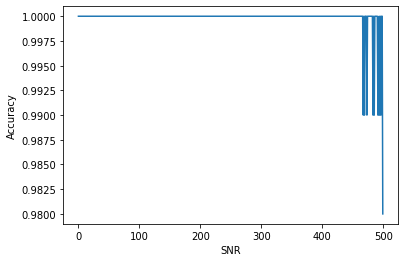

In [ ]:
#Heavily based off previous student work and tutorials from online for the training model. Tried LSTM cells and stuff too on other drafts but this worked the best i guess.

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split

#cudnnlstm is just faster apparently

#mnist = tf.keras.datasets.mnist
#(x_train, y_train) , (x_test, y_test)  = mnist.load_data()

data = wavedata
data_labels = labels
noise, noise_labels = data_noise, labels_noise
x, y = combine_data(data, noise, data_labels, noise_labels)

#print(y)

num_classes = 2
y = keras.utils.to_categorical(y, num_classes) #change to required form for our loss function ? ? ? otherwise categorical crossentropy wont work and only sparsecategorical crossentropy works
#after doing this, y = [0, 1] indicates signal, y = [1, 0] indicates noise


#print(x.shape)
#print(y.shape)
#print(x)
#print(y)

#Think we gotta use traintestsplit because our data is first strains then noise. So we use train_test_split to shuffle. We CAN, however, i think use this to test to see if this stuff works...
n_train = int(0.5 * x.shape[0]) #first half of our data should be wavedata and second half is the noise i think. If we don't shuffle
x_teststrain = x[:n_train]
x_testnoise = x[n_train:] 
#x_train, x_test = x[:n_train], x[n_train:]
#y_train, y_test = y[:n_train], y[n_train:]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #20% will be the test sample and 80% is for training

#print(x_train.shape) #60000 elements of 28 by 28 images (for mnist data) for us it is 1-0.2 * original x_train size
#print(x_train[0].shape) 
#print(y_train.shape)

#print(y_train)

#x_train = x_train/255.0
#x_test = x_test/255.0
#normalizes data for mnist data^ (need to scale btwn 0 and 1)
#we dont need to do this since all our data is btwn 0 and 1 already i thinkk

#################################################################Good CoLab Tutorial Ex: https://colab.research.google.com/github/mj-will/intro2ml/blob/master/notebooks/gravitational-wave-detection.ipynb#scrollTo=42jUth0eHb8F ############################
batch_size = 50              # number of samples in each batch of training data
input_shape = [4096, 1]      # shape of the data
n_epochs = 3                # number of epochs to train for

model = Sequential()
model.add(Conv1D(16, 
                 kernel_size=16, 
                 input_shape=input_shape, 
                 activation='relu',
                 data_format='channels_last')) #was changed from channels first because our data is channels_last i think...
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(16, 
                 kernel_size=16, 
                 activation='relu',
                 data_format='channels_last'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2)) #necessary because we have a binary classification at the end
print(model.summary())

loss = keras.losses.CategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate = 1e-3, decay = 1e-5)
metric = ['accuracy']

model.compile(loss=loss, optimizer=opt, metrics=metric)

model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs) #validation split probably not needed since we already have our train_test_split 

#Evaluate model
model.evaluate(x_test, y_test, batch_size = batch_size, verbose = 2)

#Predictions(needs softmax layer for percentages. We didn't include this in our last layer so we will do it here)
#create a new model (probability_model) with same layers as first model (model variable) plus the softmax layer
probability_model = Sequential([model,
                                keras.layers.Softmax()])
predictions = probability_model(x_teststrain)
pred0 = predictions[0]  #get the first prediction (prediction index  0)
print('prediction1 probability',pred0) #this is the probability, now we want to choose the class with highest probability
label0 = np.argmax(pred0) #takes index with highest probability, not really sure what this index means really though. 
print('prediction for index0 (takes index w/ highest probability):',label0)
#5 predictions
pred05s  = predictions [0:5] #check to see if it will predict only signal
print('pred05s shape',pred05s.shape)
label05s = np.argmax(pred05s, axis = 1)
print(label05s)

predictions2 = probability_model(x_testnoise) #check to see if it will predict only noise
pred05s2 = predictions2[0:5]
label05s2 = np.argmax(pred05s2, axis = 1)
print(label05s2)

#The first label prints all strains (index 1) which is CORRECT, second shows all NOISE (index 0) which is correct (I THINKKK). Now we just test our model on LIGO data or on that "Generate noisy data" function above. 

predictions3 = probability_model(noisydata[320]) #check to see if it will predict signal for 0 SNR (goes up to 600 SNR). Should be visible in the labels. Check to see what % of the labels are correct.
#print(noisydata[199].shape)
pred25s3 = predictions3[0:25]
label25s3 = np.argmax(pred25s3, axis = 1)
print(label25s3) #check how many of these are signal predictions (index 1's)

accuracyarray = []
snrarray = [i for i in range(0, 500)]

for i in range(0, 500):
  count = 0
  predictions4 = probability_model(noisydata[i]) #check to see if it will predict signal for 0 SNR (goes up to 600 SNR). Should be visible in the labels. Check to see what % of the labels are correct.
  #print(noisydata[199].shape)
  pred25s4 = predictions4[0:100]
  label25s4 = np.argmax(pred25s4, axis = 1)
  #print(label25s4)
  for j in range(len(label25s4)):
    if label25s4[j] == 1:
      count +=1
  accuracy = count/len(label25s4) #* 100 if you want %
  #print(accuracy, f'snr = {i}')
  accuracyarray.append(accuracy)



pp.plot(snrarray, accuracyarray)
pylab.xlabel('SNR')
pylab.ylabel('Accuracy')

#past 300 SNR it becomes harder and harder for our model to detect signals from noisy data. 


Accessing LIGO data (idk what to do with this maybe we dont have to touch this stuff tbh and can use that generate noise func like previous dude's paper. Prof seemed to be fine with that too.



https://colab.research.google.com/github/losc-tutorial/quickview/blob/master/index.ipynb

^can copy paste this if we wanna mess around with it.

Below is an image of SNR vs Accuracy. (graph isn't always the same so to stay consistent i'll probably use this graph)

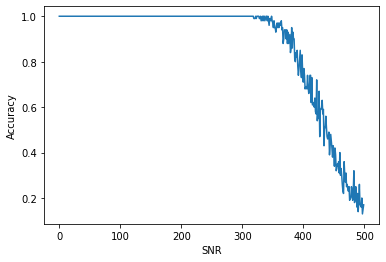